In [57]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

In [5]:
articles = pd.read_csv("../data/articles.csv")
cust = pd.read_csv("../data/customers.csv")
trans = pd.read_csv("../data/transactions_train.csv")

In [6]:
articles.shape

(105542, 25)

In [8]:
## Just a handle of description missing
articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int64 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  object
 12  perceived_colour_master_id    105542 non-null  int64 
 13 

In [9]:
print(cust.customer_id.nunique())
cust.info()

1371980
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   customer_id             1371980 non-null  object 
 1   FN                      476930 non-null   float64
 2   Active                  464404 non-null   float64
 3   club_member_status      1365918 non-null  object 
 4   fashion_news_frequency  1355971 non-null  object 
 5   age                     1356119 non-null  float64
 6   postal_code             1371980 non-null  object 
dtypes: float64(3), object(4)
memory usage: 73.3+ MB


In [10]:
cust.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [11]:
trans.shape[0]

31788324

In [12]:
trans.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [18]:
df_trans = trans.copy()
df_trans['year'] = trans.t_dat.apply(lambda date: date.split("-")[0]);
df_trans['month'] = trans.t_dat.apply(lambda date: date.split("-")[1]);


In [19]:
## To split the dataset according to this distribution. Unless we are looking into time series prediction. 
df_trans.year.value_counts(normalize=True)

2019    0.515816
2020    0.345414
2018    0.138770
Name: year, dtype: float64

In [20]:
df_trans[(df_trans['year'] == "2020")]['month'].value_counts(normalize=True)

06    0.160700
05    0.124025
07    0.123086
04    0.122119
08    0.112676
01    0.098027
03    0.095423
02    0.091243
09    0.072701
Name: month, dtype: float64

In [21]:
df_trans[(df_trans['year'] == "2019")]['month'].value_counts(normalize=True)

06    0.116254
07    0.110234
05    0.095159
04    0.090045
03    0.078475
01    0.077055
08    0.076449
09    0.074842
11    0.073064
02    0.070282
10    0.069938
12    0.068203
Name: month, dtype: float64

In [22]:
df_trans[(df_trans['year'] == "2018")]['month'].value_counts(normalize=True)

10    0.316698
11    0.288040
12    0.260430
09    0.134831
Name: month, dtype: float64

In [23]:
# df_train_trans = df_trans.groupby('year', group_keys=False).apply(lambda x: x.sample(frac=0.7))

In [25]:
# df_train_trans['year'].value_counts(normalize=True)

2019    0.515816
2020    0.345414
2018    0.138770
Name: year, dtype: float64

## Calculating customer lifetime value

Grouping customer with their transactions data

In [28]:
df = pd.merge(left= cust, right = df_trans,on ='customer_id', how="left")
df.shape

(31798023, 13)

In [29]:
df.head(1)

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,t_dat,article_id,price,sales_channel_id,year,month
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...,2018-12-27,625548001.0,0.044051,1.0,2018,12


In [30]:
df['customer_id'].nunique()

1371980

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31798023 entries, 0 to 31798022
Data columns (total 13 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   customer_id             object 
 1   FN                      float64
 2   Active                  float64
 3   club_member_status      object 
 4   fashion_news_frequency  object 
 5   age                     float64
 6   postal_code             object 
 7   t_dat                   object 
 8   article_id              float64
 9   price                   float64
 10  sales_channel_id        float64
 11  year                    object 
 12  month                   object 
dtypes: float64(6), object(7)
memory usage: 3.3+ GB


In [32]:
df['t_dat'] = pd.to_datetime(df['t_dat'])

In [40]:
df2 = df.groupby(['customer_id']).agg(recency=("t_dat", min), avg_price=("price",np.mean))

In [46]:
df['year'] = df['t_dat'].apply(lambda dat: dat.year)
df.groupby(['customer_id','year']).count().head()

FN  Active  \
customer_id                                        year                 
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d... 2018.0   0       0   
                                                   2019.0   0       0   
                                                   2020.0   0       0   
0000423b00ade91418cceaf3b26c6af3dd342b51fd051ee... 2018.0   0       0   
                                                   2019.0   0       0   

                                                           club_member_status  \
customer_id                                        year                         
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d... 2018.0                   3   
                                                   2019.0                  12   
                                                   2020.0                   6   
0000423b00ade91418cceaf3b26c6af3dd342b51fd051ee... 2018.0                   8   
                                                   2019.0                  44   

                                                           fashion_news_frequency  \
customer_id                                        year                             
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d... 2018.0                       3   
                                                   2019.0                      12   
                                                   2020.0                       6   
0000423b00ade91418cceaf3b26c6af3dd342b51fd051ee... 2018.0                       8   
                                                   2019.0                      44   

                                                           age  postal_code  \
customer_id                                        year                       
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d... 2018.0    3            3   
                                                   2019.0   12           12   
                                                   2020.0    6            6   
0000423b00ade91418cceaf3b26c6af3dd342b51fd051ee... 2018.0    8            8   
                                                   2019.0   44           44   

                                                           t_dat  article_id  \
customer_id                                        year                        
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d... 2018.0      3           3   
                                                   2019.0     12          12   
                                                   2020.0      6           6   
0000423b00ade91418cceaf3b26c6af3dd342b51fd051ee... 2018.0      8           8   
                                                   2019.0     44          44   

                                                           price  \
customer_id                                        year            
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d... 2018.0      3   
                                                   2019.0     12   
                                                   2020.0      6   
0000423b00ade91418cceaf3b26c6af3dd342b51fd051ee... 2018.0      8   
                                                   2019.0     44   

                                                           sales_channel_id  \
customer_id                                        year                       
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d... 2018.0                 3   
                                                   2019.0                12   
                                                   2020.0                 6   
0000423b00ade91418cceaf3b26c6af3dd342b51fd051ee... 2018.0                 8   
                                                   2019.0                44   

                                                           month  
customer_id                                        year           
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d... 2018.0      3  
                                    

In [49]:
df2['freq_per_year'] = df.groupby(['customer_id','year']).count().groupby(['customer_id'])['t_dat'].mean()

In [72]:
latest_trans = df['t_dat'].max()
df2['days_after_last_trans'] = df2['recency'].apply(lambda dat: (latest_trans- dat).days )
df2.head()


,recency,avg_price,freq_per_year,days_after_last_trans
customer_id,,,,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,2018-12-27,0.030904,7.000000,635.0
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,2018-09-21,0.030255,28.666667,732.0
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,2018-09-20,0.039154,6.000000,733.0
00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e,2019-06-09,0.030492,2.000000,471.0
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,2018-10-12,0.036130,4.333333,711.0


Visualing the distribution

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='avg_price', ylabel='Density'>

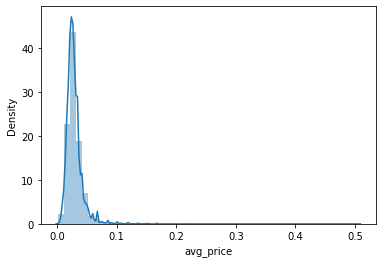

In [60]:
sns.distplot(df2['avg_price'])


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='avg_price', ylabel='Density'>

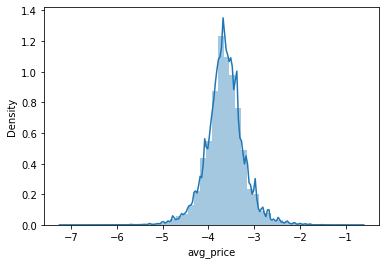

In [61]:
sns.distplot(np.log(df2['avg_price']))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='freq_per_year', ylabel='Density'>

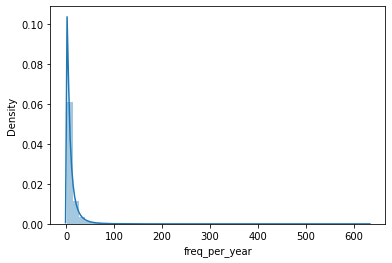

In [62]:
sns.distplot(df2['freq_per_year'])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='freq_per_year', ylabel='Density'>

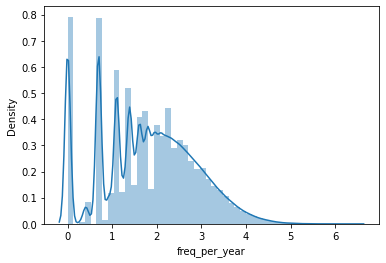

In [63]:
sns.distplot(np.log(df2['freq_per_year']))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='days_after_last_trans', ylabel='Density'>

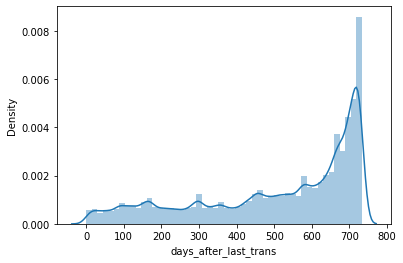

In [73]:
sns.distplot(df2['days_after_last_trans'])